# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
)

driams.loading_type = "memory"

driams.label_stats

/home/jan/Uni/master/src/maldi2resistance/data/driams.py:52: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__meta[key] = pd.read_csv(root_dir / f"{site}/id/{year}/{year}_clean.csv")
100%|██████████| 55780/55780 [00:11<00:00, 4749.47it/s]


,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,...,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
positive,1068,13366,8578,21966,628,618,4223,7383,2338,3470,...,1205,5537,12431,7616,486,580,244,3534,1707,227
negative,20941,24992,4194,4905,456,457,5813,31567,4382,24566,...,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
n_sum,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,...,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim = len(driams.selected_antibiotics))

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(driams, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory= True)

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()

        output = model(x)

        loss = criterion(output, y)
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.000266 	Learning rate: 0.001000
	Average Loss: 0.000223 	Learning rate: 0.001000
	Average Loss: 0.000209 	Learning rate: 0.001000
	Average Loss: 0.000199 	Learning rate: 0.001000
	Average Loss: 0.000191 	Learning rate: 0.001000
	Average Loss: 0.000184 	Learning rate: 0.001000
	Average Loss: 0.000178 	Learning rate: 0.001000
	Average Loss: 0.000173 	Learning rate: 0.001000
	Average Loss: 0.000168 	Learning rate: 0.001000
	Average Loss: 0.000162 	Learning rate: 0.000500
	Average Loss: 0.000146 	Learning rate: 0.000500
	Average Loss: 0.000140 	Learning rate: 0.000500
	Average Loss: 0.000136 	Learning rate: 0.000500
	Average Loss: 0.000130 	Learning rate: 0.000500
	Average Loss: 0.000126 	Learning rate: 0.000500
	Average Loss: 0.000121 	Learning rate: 0.000500
	Average Loss: 0.000118 	Learning rate: 0.000500
	Average Loss: 0.000115 	Learning rate: 0.000500
	Average Loss: 0.000109 	Learning rate: 0.000500
	Average Loss: 0.000104 	Learning rate: 0.000250
	Average Loss: 0.000

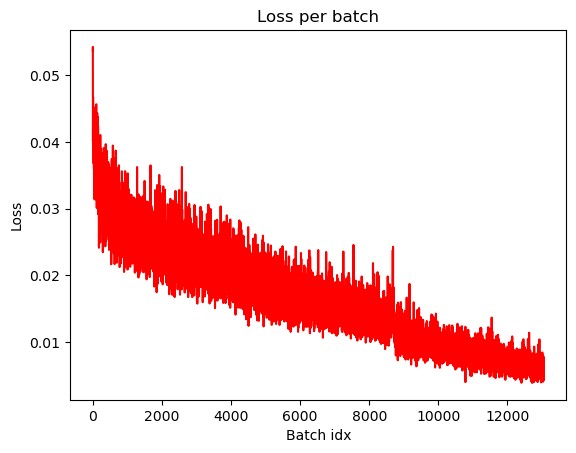

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=38, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './model.pt')